# LSTM neural network for time series prediction

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

We load and plot Tesla stock data from 2010 to 2020

In [11]:
tesla_data = pd.read_csv('datasets/TSLA_2010_2020.csv')
tesla_data = tesla_data.drop(['Date','Open','High','Low','Close','Volume'],axis = 1)
total_days = tesla_data.shape[0]
tesla_data.head()

,Adj Close
0,23.889999
1,23.830000
2,21.959999
3,19.200001
4,16.110001


<Figure size 432x288 with 0 Axes>

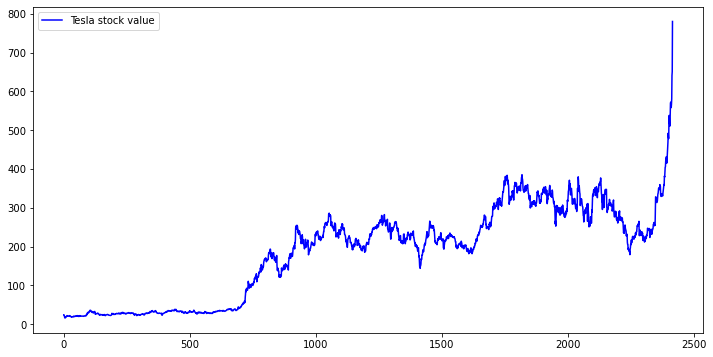

In [12]:
plt.clf()
plt.figure(figsize=(12,6))
plt.plot(tesla_data, label='Tesla stock value', c = 'b')
plt.legend()
plt.show() 

We define a sliding windows function that takes the previous days as features and the current day as target

In [13]:
def sliding_windows(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length-1):
        Xi = data[i:(i+seq_length)]
        yi = data[i+seq_length]
        X.append(Xi)
        y.append(yi)
    return np.array(X),np.array(y)

We define a class my_nn which is a neural network with LSTM layers

In [14]:
class LSTM_nn(nn.Module):
    def __init__(self,input_size, num_layers, hidden_size, seq_length):
        super(LSTM_nn, self).__init__()
        #Attributes from nn.Module
        self.input_size = input_size #input size
        self.num_layers = num_layers #number of layers
        self.hidden_size = hidden_size #hidden state
        
        #New attributes
        self.seq_length = seq_length #sequence length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first = True) #lstm
        
        self.fc =  nn.Linear(hidden_size, 1) #fully connected linear
    
    def forward(self,X):
        h_0 = Variable(torch.zeros(self.num_layers, X.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, X.size(0), self.hidden_size)) #internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(X, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size)

        # Propagate input through fully connected linear neuron
        out = self.fc(hn)
        
        return out

We process the data for training and testing

In [15]:
def process_data(data, seq_length, train_proportion, scaler):
    data_normalized = scaler.fit_transform(np.array(data))
    X,y = sliding_windows(data_normalized,seq_length)
    train_size = int(len(y) * train_proportion)

    X_data = Variable(torch.Tensor(X))
    y_data = Variable(torch.Tensor(y))

    X_train = Variable(torch.Tensor(X[0:train_size]))
    y_train = Variable(torch.Tensor(y[0:train_size]))

    X_test = Variable(torch.Tensor(X[train_size:len(X)]))
    y_test = Variable(torch.Tensor(y[train_size:len(X)]))
    
    return data_normalized, X_data, y_data, X_train, y_train, X_test, y_test

In [16]:
seq_length = 15
train_proportion = 2/3
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized, X_data, y_data, X_train, y_train, X_test, y_test = process_data(tesla_data, seq_length, train_proportion, scaler)

We create a recurrent neural network with our LSTM_nn class

In [17]:
my_model = LSTM_nn(input_size = 1, num_layers = 1, hidden_size = 128, seq_length = seq_length)

We train our model 

In [21]:
num_epochs = 500
learning_rate = 0.001
criterion = nn.MSELoss()    
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate) 
t = trange(num_epochs+1)
for epoch in t:
    #Pass through the neural network
    train_outputs = my_model.forward(X_train) 
    test_outputs = my_model.forward(X_test) 

    #Reset gradients to zero  
    optimizer.zero_grad() 
    
    train_loss = criterion(train_outputs, y_train)
    test_loss = criterion(test_outputs,y_test)

    #Backprogagation step
    train_loss.backward()
    
    #Update weights and bias of the network
    optimizer.step()
    
    #Print train and test loss
    t.set_description("Epoch: %d, Train loss: %1.5f, Test loss: %1.5f" % (epoch, train_loss.item(),test_loss.item()))


Epoch: 500, Train loss: 0.00039, Test loss: 0.00532: 100%|██████████| 501/501 [03:06<00:00,  2.68it/s]


We make prediction on all data

<Figure size 432x288 with 0 Axes>

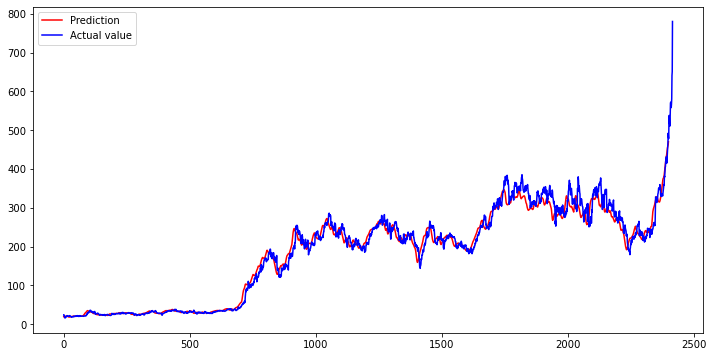

In [22]:
prediction = my_model.forward(X_data).detach().numpy()
prediction = scaler.inverse_transform(prediction)
plt.clf()
plt.figure(figsize=(12,6))
plt.plot(prediction, label='Prediction', c = 'r')
plt.plot(tesla_data, label='Actual value', c = 'b')
plt.legend()
plt.show() 